# PSF Extractor
---

#### Overview
1. Initialize parameters
2. Create stack
3. Find features
4. Mass-based (brightness) filtering
5. Filter out overlapping features
6. Extract PSFs
7. Filter out strange PSFs
8. Localize PSFs
9. Characterize PSF

#### Libraries

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import trackpy
import psf_extractor as psfe

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

#### Interactive plotting

In [3]:
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, FloatLogSlider
%matplotlib inline

## 1) Initialize parameters
---

Expected feature diameters in $x$, $y$, and optionally $z$ are needed for initial feature detection with `trackpy.locate`. These can either be provided or estimated from known optical parameters such as the numerical aperture, emission wavelength, and pixel size.

In [4]:
# Set pixel sizes [nm/px]
psx = 108
psy = psx
psz = 300

# Set optical parameters:
NA = 0.95  # numerical aperture
lambda_em = 520  # emission wavelength

# Set expected feature diameters [nm]
dx_nm = lambda_em / NA 
dy_nm = dx_nm
dz_nm = 3 * dx_nm

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer (as per `trackpy` instructions)
dx, dy, dz = np.ceil([dx, dy, dz]).astype(int) // 2 * 2 + 1

# Set PSF window
wx = int(np.round(4 * dx_nm/psx))  # px
wy = int(np.round(4 * dy_nm/psx))  # px
wz = 2 * wx                        # px

# Output
out = f"""\
Optical settings
----------------
NA.............. {NA:.2f}
Wavelength...... {lambda_em:.0f} nm
Pixelsize x..... {psx:.1f} nm/px
Pixelsize y..... {psy:.1f} nm/px
Pixelsize z..... {psz:.1f} nm/px
Diameter x...... {dx:.0f} px ({dx_nm:.1f} nm)
Diameter y...... {dy:.0f} px ({dy_nm:.1f} nm)
Diameter z...... {dz:.0f} px ({dz_nm:.1f} nm)
PSF window x.... {wx:.0f} px ({wx*psx:.0f} nm)
PSF window y.... {wy:.0f} px ({wy*psy:.0f} nm)
PSF window z.... {wz:.0f} px ({wz*psz:.0f} nm)
"""
print(out)

Optical settings
----------------
NA.............. 0.95
Wavelength...... 520 nm
Pixelsize x..... 108.0 nm/px
Pixelsize y..... 108.0 nm/px
Pixelsize z..... 300.0 nm/px
Diameter x...... 7 px (547.4 nm)
Diameter y...... 7 px (547.4 nm)
Diameter z...... 7 px (1642.1 nm)
PSF window x.... 20 px (2160 nm)
PSF window y.... 20 px (2160 nm)
PSF window z.... 40 px (12000 nm)



## 2) Create stack
---

In [5]:
# Set directory of image stack
file_pattern = '../data/sample_zstack/'
# Load image stack
stack = psfe.load_stack(file_pattern)

INFO:root:Creating stack from directory.


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:root:(34, 2048, 2048) image stack created succesfully.


## 3) Find features
---
The first step in the workflow is to detect features (e.g. fluorescent beads) within a 3D image stack. Features are found using `trackpy.locate`, which takes the image stack and expected feature diameters as input. No constraints are provided to `trackpy.locate` such that it returns all possible features on the scale of the expected feature dimensions. We then go through a series of filtering steps to end up with a feature set that ought to be single PSF localizations.

#### Maximum intensity projection in `z`

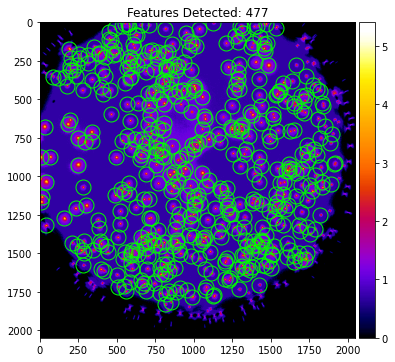

In [6]:
# Get MIP
mip = np.max(stack, axis=0)

# Locate features
features_init = trackpy.locate(mip, diameter=[dy, dx]).reset_index(drop=True)

# Plot MIP
psfe.plot_mip(mip, features=features_init)

## 4) Mass-based filtering
---

The mass is the "integrated brightness" of a feature. It is important to choose reasonable lower and upper bounds to filter out spurious features (salt) smaller than the PSF and clusters larger than the PSF. It's difficult to know these bounds _a priori_, as the appropriate bounds will vary from dataset to dataset. So it is useful to sample a logarithmic range of candidate bounds and choose proper minimum and maximum masses based on visual inspection.

#### Choose minimum mass

In [7]:
# Choose minimum mass range
min_masses = psfe.get_min_masses(mip, dx=dx, n=35, b=20)

# Interactive plot
widget = interact(psfe.plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(min_masses),
                                      min=np.log10(min_masses.min()),
                                      max=np.log10(min_masses.max())),
                  features=fixed(features_init),
                  filtering=fixed('min'));

interactive(children=(FloatLogSlider(value=7.593356329610143, description='mass', max=2.1814637759386293, min=…

In [8]:
# Set minimum mass
min_mass = widget.widget.children[0].value
# min_mass = 3

#### Choose maximum mass

In [9]:
# Get candidate maximum masses
max_masses = psfe.get_max_masses(min_mass, n=31, b=20)

widget = interact(psfe.plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(max_masses),
                                      min=np.log10(max_masses.min()),
                                      max=np.log10(max_masses.max())),
                  features=fixed(features_init.loc[features_init['raw_mass'] > min_mass]),
                  filtering=fixed('max'));

interactive(children=(FloatLogSlider(value=13.416407864998737, description='mass', max=1.7781512503836436, min…

In [10]:
# Set maximum mass
max_mass = widget.widget.children[0].value
# max_mass = 15

# Update feature set
features_minmass = features_init.loc[(features_init['raw_mass'] > min_mass)]
features_mass = features_init.loc[(features_init['raw_mass'] > min_mass) &\
                                  (features_init['raw_mass'] < max_mass)]

# Output
out = f"""\
Minimum mass................ {min_mass:.2f}
Maximum mass................ {max_mass:.2f}
Initial features............ {len(features_init):.0f}
Too dim (min filtered)...... {len(features_init.loc[features_init['raw_mass'] < min_mass]):.0f}
Too bright (max filtered)... {len(features_init.loc[features_init['raw_mass'] > max_mass]):.0f}
Remaining features.......... {len(features_mass):.0f}
Random sample of features...
"""
print(out)
features_mass.sample(5)

Minimum mass................ 3.00
Maximum mass................ 15.00
Initial features............ 477
Too dim (min filtered)...... 30
Too bright (max filtered)... 3
Remaining features.......... 444
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep
181,706.442793,1303.898960,0.931132,1.541887,0.083563,0.098232,4.793722,0.008946
97,368.071146,1423.176548,1.050118,1.536555,0.144181,0.110684,4.385650,0.009834
380,1448.451730,1379.222222,0.759572,1.654051,0.077314,0.070561,3.663677,0.011931
139,523.320951,1651.233284,0.931132,1.588873,0.133973,0.092698,4.071749,0.010648
281,1111.281690,578.632629,1.178789,1.599222,0.082851,0.116219,5.098655,0.008380


## 5) Filter out overlapping and edge features
---

Overlapping PSFs must be removed so that they do not distort the PSF characterization. To remove them, a virtual bounding box is created around each feature and checked for overlap against every other feature's bounding box. PSFs along the edge of the stack are likewise removed.

Features are rejected when another (too bright) feature is nearby, even if the box for this feature is not shown in the plot.

  0%|          | 0/48 [00:00<?, ?it/s]

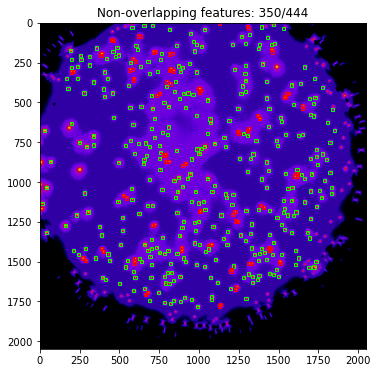

In [11]:
# Detect overlapping features
overlapping = psfe.detect_overlapping_features(features_minmass, wx, wy)
# Detect edge features
Dz, Dy, Dx = stack.shape  # stack boundaries
edges = psfe.detect_edge_features(features_mass, Dx, Dy, wx, wy)
# Combine
overlapping = np.concatenate([overlapping, edges])

# Plot overlapping and edge features
psfe.plot_overlapping_features(mip, features_mass, overlapping, wx, wy)

In [12]:
# Update feature set
features_overlap = features_mass.loc[~features_mass.index.isin(overlapping)]

# Output
out = f"""\
Initial features............ {len(features_mass):.0f}
Overlapping features........ {overlapping.size:.0f}
Remaining features.......... {len(features_overlap):.0f}
Random sample of features...
"""
print(out)
features_overlap.sample(5)

Initial features............ 444
Overlapping features........ 94
Remaining features.......... 350
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep
382,1449.273600,861.758400,0.864722,1.644384,0.032599,0.080246,4.080718,0.010623
91,351.304577,166.695423,0.785859,1.677313,0.177066,0.069178,3.417040,0.012868
349,1363.431925,702.256651,0.884091,1.641595,0.044454,0.084397,4.044843,0.010724
147,540.955705,1438.981208,1.030748,1.530452,0.130848,0.106534,4.461884,0.009655
130,469.755697,1727.917046,1.517760,1.679682,0.183495,0.130054,6.663677,0.006326


## 6) Extract PSFs
---

All of the filtered PSFs must be extracted before they can be aligned and averaged. We already have the rough coordinates of each PSF from filtering the features detected by `trackpy.locate`. So we simply define a subvolume containing the PSF and extract.

#### Define subvolume and extract PSFs

In [13]:
# Extract PSFs
psfs = psfe.extract_psfs(stack,
                         features=features_overlap,
                         shape=(wz, wy, wx))

#### Plot the maximum intensity projection of each extracted PSF

  0%|          | 0/350 [00:00<?, ?it/s]

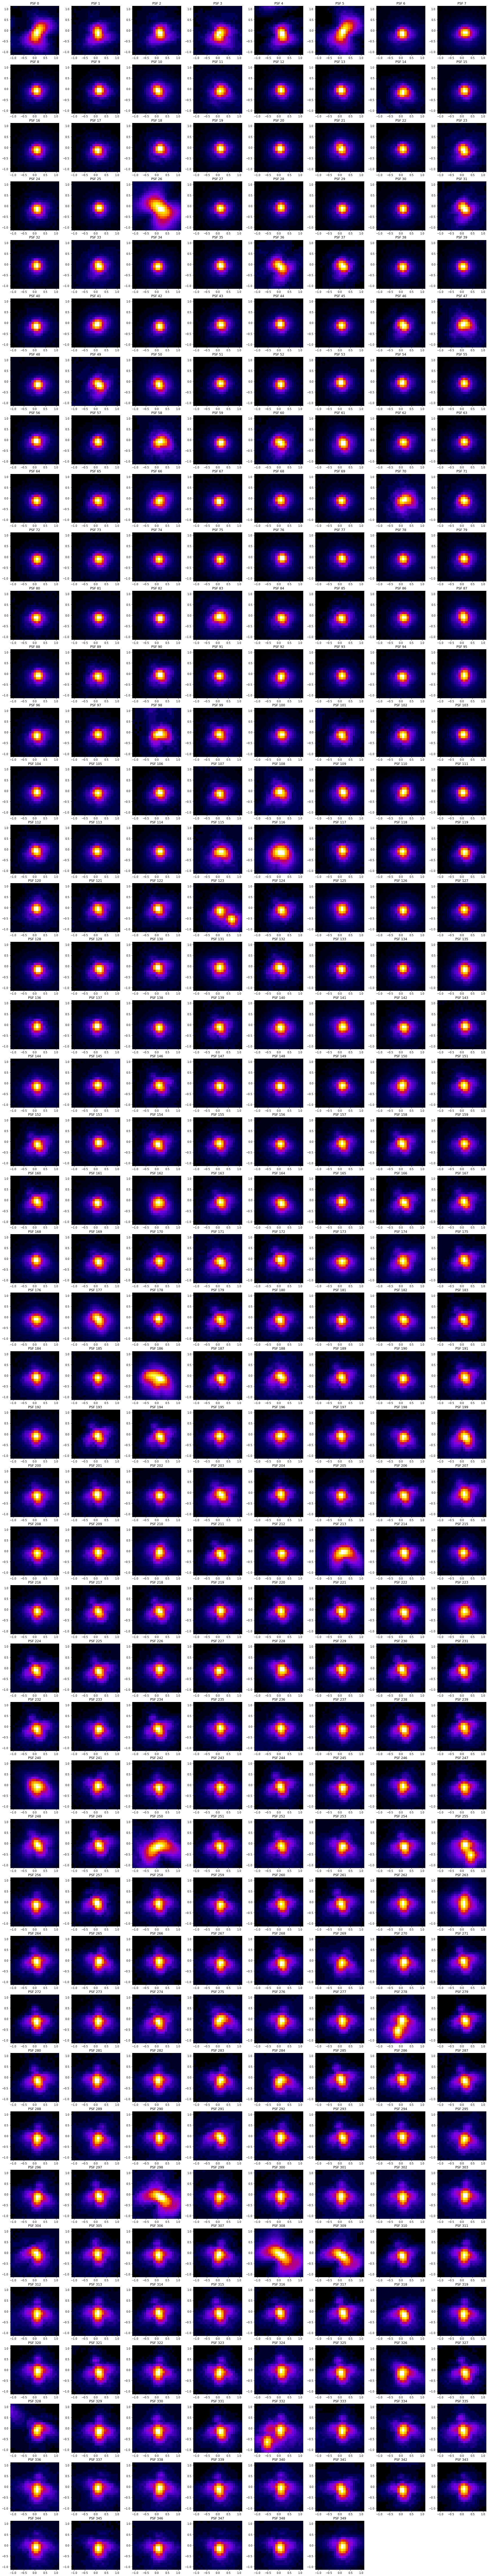

In [14]:
# Plot PSF MIPs
psfe.plot_psfs(psfs, psx, psy)

## 7) Filter out strange PSFs
---

Use the Pearson correlation coefficient to filter out oultier PSFs. Each PSF is compared to every other PSF. Outlier criteria is based on a PSF having a PCC that frequently falls below 0.9. Why 0.9? Would you be satisfied with less than an "A"? Didn't think so...

Why isn't once enough? Because it takes 2 PSFs to generate a wild PCC value. One of these PSFs may be totally fine, but the only way to tell a typical PSF from an outlier is by checking the number of occurences each PSF falls in the outlier range.

How many times is frequently? A bit arbitrary, but 3× the average number of occurences seems to work empirically.

In [15]:
# Set minimum PCC threshold
pcc_min = 0.93

# Detect outlier PCCs
outliers_, pccs = psfe.detect_outlier_psfs(psfs, pcc_min=pcc_min, return_pccs=True)

# Stupid index trick thingy
df = features_overlap.reset_index()
outliers = df[df.index.isin(outliers_)]['index'].values

  0%|          | 0/61075 [00:00<?, ?it/s]

#### Plot distribution of Pearson correlation coefficients

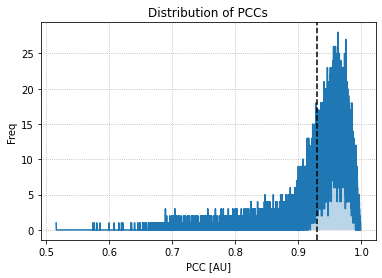

In [16]:
psfe.plot_pcc_distribution(pccs, pcc_min=pcc_min, bins=pccs.size//2)

In [17]:
# Update feature set
features_pearson = features_overlap.loc[~features_overlap.index.isin(outliers)]

# Output
out = f"""\
Initial features............ {len(features_overlap):.0f}
Outlier features............ {outliers.size:.0f}
Remaining features.......... {len(features_pearson):.0f}
Random sample of features...
"""
print(out)
features_pearson.sample(5)

Initial features............ 350
Outlier features............ 14
Remaining features.......... 336
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep
220,855.025074,1699.629794,0.938050,1.642000,0.118093,0.085780,4.255606,0.010156
117,441.646999,277.460834,1.360034,1.577435,0.125562,0.138355,5.367713,0.007937
417,1532.109402,1036.841026,0.809380,1.609268,0.015472,0.076096,3.910314,0.011121
145,538.795664,706.121951,2.552658,1.595726,0.034805,0.251807,10.237669,0.004056
186,722.997677,1157.067364,1.191241,1.542281,0.105109,0.123136,5.000000,0.008555


## 8) Localize PSFs
---

The individual PSF positions must be localized with subpixel accuracy in $x$, $y$, and $z$. First, we fit a 2D Gaussian to each PSF in the maximum intensity projection to get the $x$, $y$ position. Then we fit a 1D Gaussian to the line profile through the center of the PSF to get the $z$ position.

* 2D Gaussian fit for $x$, $y$ localization 
* 1D Gaussian fit for $z$ localization
  * Might it be better to sum/integrate in x, y?

In [18]:
# Re-extract PSFs based on updated feature set
psfs = psfe.extract_psfs(stack, features=features_pearson, shape=(wz, wy, wx))

# Localize PSFs
locations = psfe.localize_psfs(psfs, integrate=False)
locations.head()

  0%|          | 0/336 [00:00<?, ?it/s]

,x0,y0,z0,sigma_x,sigma_y,sigma_z
0,10.90987,11.345624,17.083732,1.821463,2.381532,1.083124
1,11.512885,11.340641,17.011658,1.794012,2.160793,1.072129
2,11.008735,11.883443,16.566039,2.205883,2.489698,1.174027
3,11.507221,11.883133,17.076277,1.758336,2.441466,1.028452
4,10.749321,11.528439,16.954117,1.697939,1.684396,1.08671


#### Plot localization data

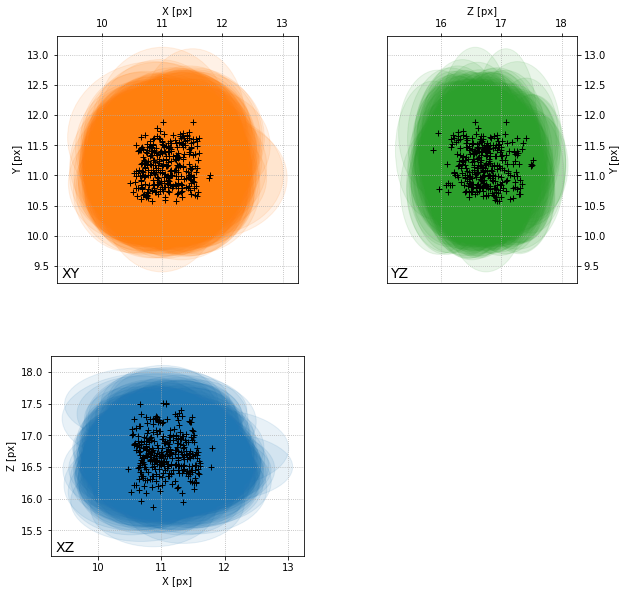

In [19]:
psfe.plot_psf_localizations(locations)

## 9) Characterize PSF
---

Upsample and align PSFs

#### Upsample and align PSFs

In [20]:
# Set upsample factor
usf = 5

# Align PSFs
psf_sum = psfe.align_psfs(psfs, locations, upsample_factor=usf)

  0%|          | 0/336 [00:00<?, ?it/s]

#### Plot PSF

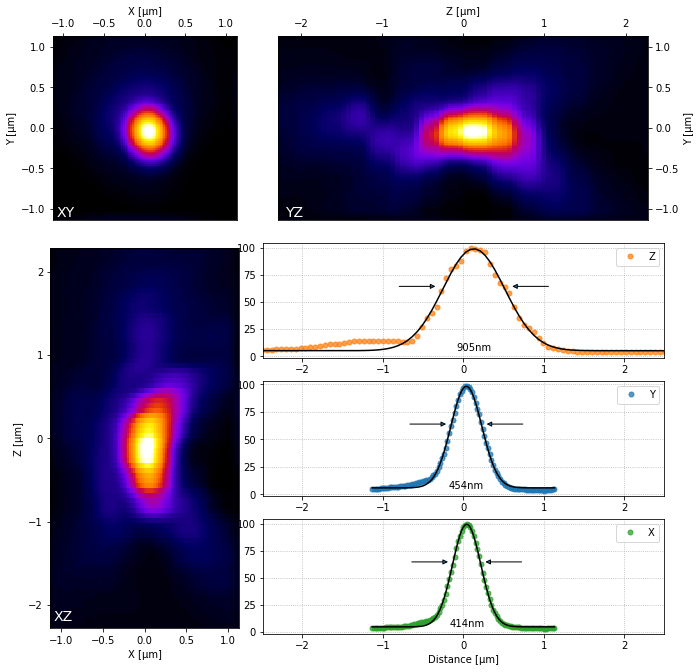

In [21]:
# Plot PSF
psfe.plot_psf(psf_sum, psx/usf, psy/usf, psz/usf)